In [8]:
!pip install datasets transformers pandas torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 64.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 711.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
from datasets import load_dataset
import pandas as pd
import os
import re

In [3]:
dataset = load_dataset("zeroshot/twitter-financial-news-topic")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16990
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4117
    })
})

In [12]:
# Data cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [15]:
# @title label
df_train['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

NameError: name 'df_train' is not defined

In [9]:
df_test.head()

,text,label
0,Analyst call of the day for @CNBCPro subscribe...,0
1,"Loop upgrades CSX to buy, says it's a good pla...",0
2,BofA believes we're already in a recession — a...,0
3,JPMorgan sees these derivative plays as best w...,0
4,Morgan Stanley's Huberty sees Apple earnings m...,0


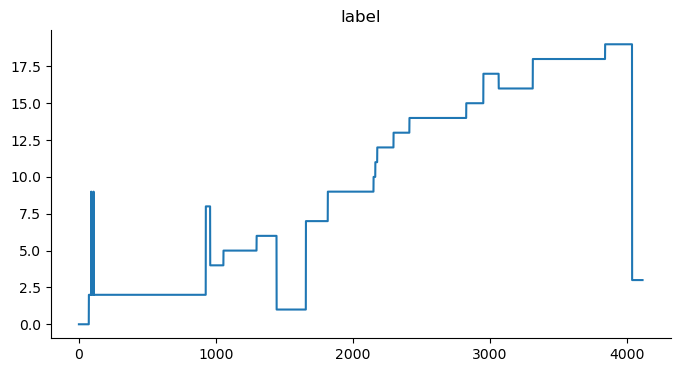

In [10]:
# @title label

df_test['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

In [12]:
df_train.head()

,text,label
0,here are thursdays biggest analyst calls apple...,0
1,buy las vegas sands as travel to singapore bui...,0
2,piper sandler downgrades docusign to sell citi...,0
3,analysts react to teslas latest earnings break...,0
4,netflix and its peers are set for a return to ...,0


In [13]:
df_test.head()

,text,label
0,analyst call of the day for subscribers goldm...,0
1,loop upgrades csx to buy says its a good place...,0
2,bofa believes were already in a recession and...,0
3,jpmorgan sees these derivative plays as best w...,0
4,morgan stanleys huberty sees apple earnings mi...,0


In [14]:
print(df_train["label"].unique())
print(df_test["label"].unique())


[ 0  2  9  8  4  5  6  1  7 10 11 12 13 14 15 17 16 18 19  3]
[ 0  2  9  8  4  5  6  1  7 10 11 12 13 14 15 17 16 18 19  3]


In [ ]:
# SageMaker training job setup
role = sagemaker.get_execution_role()
pytorch_estimator = PyTorch(entry_point='train.py',
                            source_dir='.',
                            role=role,
                            framework_version='1.7.1',
                            py_version='py3',
                            instance_count=1,
                            instance_type='ml.m5.2xlarge',
                            hyperparameters={'epochs': 1},
                            use_spot_instances=True,
                            max_run=3600,  # Maximum runtime in seconds
                            max_wait=7200)  # Maximum wait time for Spot Instances 

# Start the training job
pytorch_estimator.fit()

In [14]:
import sagemaker
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

# Define the processor
pytorch_processor = PyTorchProcessor(
    framework_version='1.7.1',
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    command=['python3'],
)

# Use the processor
pytorch_processor.run(
    code='test.py',
    source_dir='.',
    inputs=[ProcessingInput(
        source='./model', 
        destination='/opt/ml/processing/model'
    )],
    arguments=['--arg1', 'value1'],
)


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded . to s3://sagemaker-us-east-1-532114563603/pytorch-2024-03-26-07-33-09-103/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-532114563603/pytorch-2024-03-26-07-33-09-103/source/runproc.sh
INFO:sagemaker:Creating processing-job with name pytorch-2024-03-26-07-33-09-103


  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-py3-none-any.whl size=3160 sha256=3f29978d0cc26ab2d823b4941ee38b552e52a162111428f5cdc9086f6754f0c3
  Stored in directory: /root/.cache/pip/wheels/6a/f5/9c/f8331a854f7a8739cf0e74c13854e4dd7b1af11b04fe1dde13
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895254 sha256=c666350d13571ffeb8db5fe24e6783f624baca3cb8509ac875820a275448b91d
  Stored in directory: /root/.cache/pip/wheels/4c/64/31/e9900a234b23fb3e9dc565d6114a9d6ff84a72dbdd356502b4
Successfully built idna-ssl sacremoses
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2021.5.0
    Uninstalling fsspec-2021.5.0:
      Successfully uninstalled fsspec-2021.5.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 4.0.0
    Uninstalling pyarrow-4.0.0:
      Successfu